In [4]:
%matplotlib inline
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
from sklearn import preprocessing, model_selection, decomposition, linear_model, ensemble, metrics

sns.set_style('whitegrid')
sns.set_context('paper')

# Exposure Data Predictions 

In this notebook we are just looking at whether we can predict any exposure vs control: i.e. can we detect perturbation/distress is there any signal overall

## Data Parsing

In [5]:
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn

raw_data = pd.read_csv('Pharmaceuticals-Normalized-Data.txt', sep='\t').set_index('Probe')
cbz_data = raw_data[[x for x in raw_data.columns if "CBZ" in x]]
exposure_labels = []
gender = []
for sample in cbz_data.columns:
    # if sample is a control
    if sample[-2] == 'C':
        exposure_labels.append(0)
    else:
        exposure_labels.append(1)
    
    if "Female" in sample:
        gender.append(1)
    else:
        gender.append(0)
        
# take the transpose to make it the appropriate orientation
cbz_data = cbz_data.T

# add these labels
cbz_data['gender'] = gender
cbz_data['exposure'] = exposure_labels

## Exploratory Data Analysis

In [6]:
# visualise your data
#sns.clustermap(cbz_data.iloc[:1000])

In [7]:
# describe samples by exposure type
#exposure_features = cbz_data.groupby('exposure').describe()

In [8]:
# which  features are highest average in exposure
# which are lowest 
# how about the variance

## Test-train splitting

The dataset now needs split into training and test-sets

In [9]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(cbz_data.drop('exposure', axis=1), 
                                                                    cbz_data['exposure'], 
                                                    test_size=0.20, random_state=42)

## Normalization 

Normalise the ranges involved as it makes PCA/dimensionality reduction more stable

In [10]:
# we need to apply the same transform at the end
min_max_scaler = preprocessing.MinMaxScaler()
X_train_scaled = min_max_scaler.fit_transform(X_train)

## PCA

PCA is divided into 2 parts: data visualization and speed up machine learning algorithm 

In [11]:
# can't use "mle" because we have so few samples
pca = decomposition.PCA(n_components=10, random_state=42)
X_train_scaled_pca = pca.fit_transform(X_train_scaled)

Text(0.5, 0, 'Principal Components')

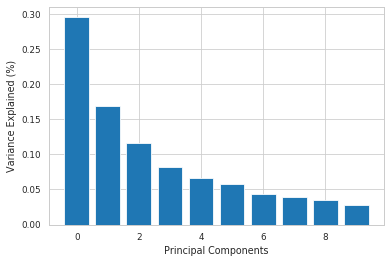

In [12]:
plt.bar(range(pca.n_components), pca.explained_variance_ratio_)
plt.ylabel('Variance Explained (%)')
plt.xlabel("Principal Components")

Text(0.5, 1.0, 'CBZ Training PCA')

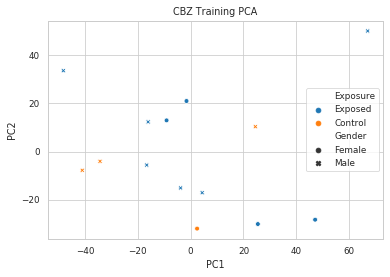

In [13]:
# get first two PCs
pca_train_for_plotting = pd.DataFrame(X_train_scaled_pca, index=y_train.index)
pca_train_for_plotting['Exposure'] = y_train.replace({1: 'Exposed', 0: 'Control'})
pca_train_for_plotting['Gender'] = X_train['gender'].replace({1: 'Female', 0: 'Male'})
sns.scatterplot(data = pca_train_for_plotting, x=0, y=1, hue='Exposure', style='Gender')
plt.ylabel('PC2')
plt.xlabel('PC1')
plt.title("CBZ Training PCA")

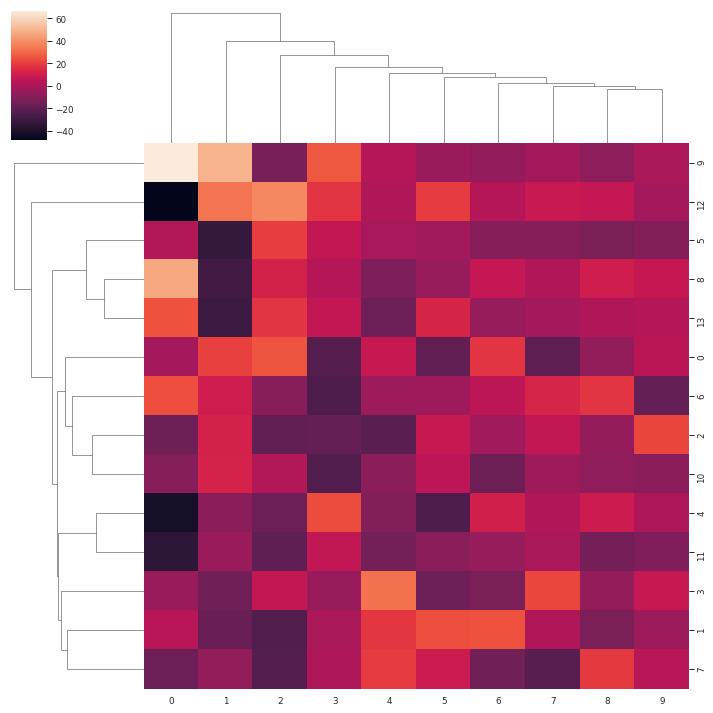

In [14]:
sns.clustermap(X_train_scaled_pca,  )

## Fit Model

Start with a simple model like logistic regression

You can also try random forest

We need 6 instances as we want to try training each type of model on:
- non-normalised data
- normalised data
- decomposed (PCA) data

In [15]:
train_scores = {}

lr_clf = linear_model.LogisticRegression(penalty='none')
lr_clf.fit(X_train, y_train)
train_scores['Logistic Regression'] = lr_clf.score(X_train, y_train)


lr_clf_norm = linear_model.LogisticRegression(penalty='none')
lr_clf_norm.fit(X_train_scaled, y_train)
train_scores['Logistic Regression Normalised'] = lr_clf_norm.score(X_train_scaled, y_train)


lr_clf_pca = linear_model.LogisticRegression(penalty='none')
lr_clf_pca.fit(X_train_scaled_pca, y_train)
train_scores['Logistic Regression PCA'] = lr_clf_pca.score(X_train_scaled_pca, y_train)

In [16]:
rf_clf = ensemble.RandomForestClassifier()
rf_clf.fit(X_train, y_train)
train_scores['Random Forest'] = rf_clf.score(X_train, y_train)

rf_clf_norm = ensemble.RandomForestClassifier()
rf_clf_norm.fit(X_train_scaled, y_train)
train_scores['Random Forest Normalised'] = rf_clf_norm.score(X_train_scaled, y_train)

rf_clf_pca = ensemble.RandomForestClassifier()
rf_clf_pca.fit(X_train_scaled_pca, y_train)
train_scores['Random Forest PCA'] = rf_clf_pca.score(X_train_scaled_pca, y_train)

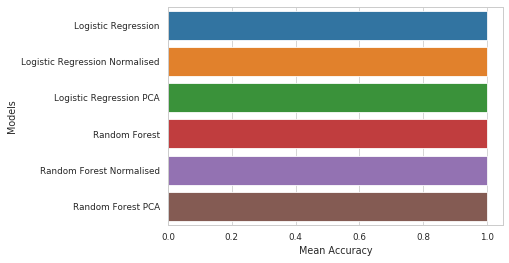

In [17]:
train_score_df = pd.Series(train_scores, name='Mean Accuracy').reset_index().rename(columns={'index': 'Models'})
sns.barplot(data = train_score_df, x='Mean Accuracy', y='Models')

## Test set performance

Need to preprocess our test set in the same way as our training set but we can only really select one model to prevent over-fitting to our test-set

In [18]:
X_test_scaled = min_max_scaler.transform(X_test)
X_test_scaled_pca = pca.transform(X_test_scaled)

In [19]:
y_pred = lr_clf.predict(X_test)
print(metrics.classification_report(y_test, y_pred, target_names=['Exposed', 'Control']))

              precision    recall  f1-score   support

     Exposed       0.00      0.00      0.00         2
     Control       0.50      1.00      0.67         2

    accuracy                           0.50         4
   macro avg       0.25      0.50      0.33         4
weighted avg       0.25      0.50      0.33         4



/home/fin/miniconda3/envs/eda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
